### Ordinary Differential Equations & Parameter Estimation with Gradient Descent

### Background
Ordinary differential equations (ODE) appear naturally in many fields and are commonly used for modeling physical processes.\
An ODE is defined as: 
$$
\dot{u} = \frac{du}{dt} = f(u, p, t)
$$
where $t$ is the independent variable, $u$ is the state of the system, $p$ are the parameters and $f$ describes how $u$ changes. 


In [1]:
using PyCall
using DifferentialEquations
using Distributions
using Plots
using Random
using LinearAlgebra
using ForwardDiff: gradient
using ParameterizedFunctions

### Lotka Volterra 
The Lotka Volterra system is a dynamical system describing predator-prey interaction
for two populations over a given time interval. It consists of two first order nonlinear
differential equations.
$$
\dot{x} = α · x − β · xy
$$
$$
\dot{y} = δ · xy − γ · y
$$

The Lotka Volterra equation ẋ describes the change through
time of the number of rabbits and the second the change through time of the number
of foxes.


For every problem you want to solve you first define a problem, solve the problem and then analyze the solution. 
First we define the Lotka Volterra system and the ODEProblem, which is subsequently solved numerically. For this we commonly use a Runge Kutta solver. You may define the algorithm in the solve function explicitly. In our case we use the default solver which is in this case the Tsit5(). The package provides a default selection of a solver, depending on some properties of your system(stiffness, tolerances). You can also support the solver with some hints with alg_hints. This is a very convenient feature, as you may not always know which solver fits best.\
To solve the system the initial conditions $u0$ as well as $tspan$ has to be defined depending on the defined system (see initial-value-problem).


In [11]:
function lotka_volterra!(du,u,p,t)
    α, β, γ, δ = p
    x, y = u
    du[1] = dx = α*x - β*x*y
    du[2] = dy = -δ*y + γ*x*y
end

function ODESolver(α, β, γ, δ)
    u0 = [1.0,1.0]
    tspan = (0.0,10.0)
    p = α, β, γ, δ
    prob = ODEProblem(lotka_volterra!,u0,tspan,p)
    sol = solve(prob, reltol=1e-6, saveat=0.1)
    return(sol)
end

ODESolver (generic function with 1 method)

Note that the order of the arguments given to ODEProblem() is important. The parameters $p$ are given last to the function, because they are optional. The derivative function lotka_volterra() has the independent variable $t$ last, because partial differential equations(PDE) definitions can have more than one independent variable. 

### Create dataset as ground truth
We sample the parameters of the ODE uniformly between 1.0 and 3.0 and solve the ODE for this parameter.  

Reference Data Parameter: α:2.0663660320877226β:1.9080582711742848γ:1.0353736534299287δ:1.3458660578739026

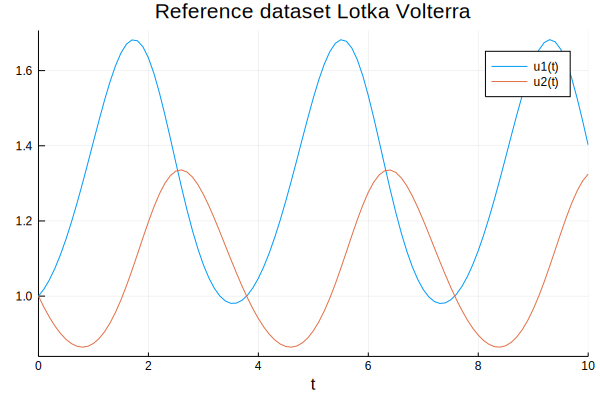

In [12]:
function random_dataset(seed)
    Random.seed!(seed)
    α = rand(Uniform(1.0,3.0))
    β = rand(Uniform(1.0,3.0))
    γ = rand(Uniform(1.0,3.0))
    δ = rand(Uniform(1.0,3.0))
    print("Reference Data Parameter: ",  "α:", α , "β:", β, "γ:", γ, "δ:", δ)
    return (α, β, γ, δ), ODESolver(α, β, γ, δ)
end

function plot_ode(sol, title)
    plt = plot(sol, title=title)
    # savefig(plt, title)
    # display(plt) -> if developing Julia in spacemacs
end

θ_star, dat = random_dataset(42)
plot_ode(dat, "Reference dataset Lotka Volterra")

### Calculate L2 loss 
In the next step we define a loss function. In this example we use an Euclidean distance as loss. 


In [13]:
function f(θ)
    α, β, γ, δ = θ
    pred = ODESolver(α, β, γ, δ)
    l2_loss = norm(pred[1,:] - dat[1,:]) + norm(pred[2,:]-dat[2,:])
    return l2_loss
end

f (generic function with 1 method)

### Background Automatic Differentiation
If you are not familiar with Automatic Differentiation, I will now introduce it briefly. Why do we not calculate the derivatives manually? Because it is time consuming and prone to error. You can think of Automatic Differentiation as something similiar to backpropagation but more general. (For more details: [Automatic Differentiation in Machine Learning: a Survey](https://jmlr.org/papers/v18/17-468.html))\
However we use ForwardDiff to calculate the gradient to the entire computation graph.




In [14]:
function gradient_descent(θ, iter, α = 0.001)
    trace = []
    ∇f(x) = gradient(f, θ)
    for it in collect(range(1, iter, step=1))
        push!(trace, f(θ))
        grad_f = ∇f(θ)
        θ = θ - α * grad_f
    end
    return θ, trace
end

gradient_descent (generic function with 2 methods)

### Evaluation
Before running the gradient descent we need to define the numer of iterations and the starting values of the parameter. Please note that the algorithm is sensitive to the initial condition (because many local optima exist).
Now we can start the gradient descent. We are saving the loss value to observe how it decreases. As you can see, the final parameters are very close to the ground truth.

In [15]:
iter = 10000
θ = [2.0,1.0,1.0,1.0]
θ, trace = gradient_descent(θ, iter)

println("original θ:", θ_star)
println("final θ:", θ)
println("initial loss:", trace[1])
println("final loss:", trace[end])


original θ:(2.0663660320877226, 1.9080582711742848, 1.0353736534299287, 1.3458660578739026)
final θ:[2.0512940476718593, 1.8881091644667114, 1.0446334619954878, 1.3603327482796854]
initial loss:17.50882971761695
final loss:0.7360474138462729


Since we want to evaluate our result based on the Lotka Volterra system, we fill in the found values in and integrate the system with the predicted parameters. Afterwards we are plotting the results.

(If you want to use Latex in your Plotting labels, you can use LaTeXStrings. :))

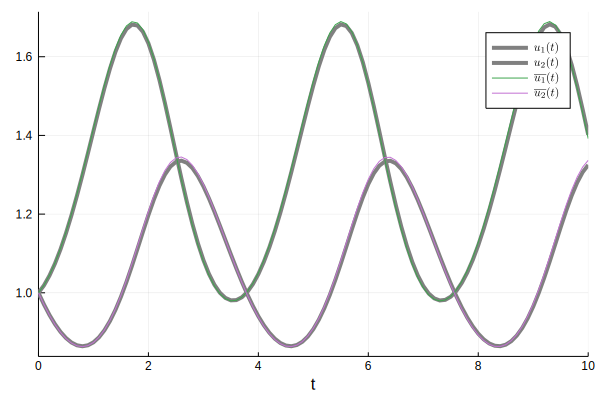

In [16]:
using LaTeXStrings
gd_pred = ODESolver(θ...)

p = plot(dat,linewidth = 4,linecolor=:grey, label = [L"u_{1}(t)" L"u_{2}(t)"])
plot!(p, gd_pred , label = [L"\overline{u_{1}}(t)" L"\overline{u_{2}}(t)"])

In the plot, the colored curves represent the estimation and the grey ones the ground truth. As you can see, Gradient descent estimates our parameters quite well.

### Call a Python package

Suppose we want to use a Python package in Julia. For this purpose we use [PyCall](https://github.com/JuliaPy/PyCall.jl), a package which enables to call Python from 
Julia providing automatic type conversion. You can either use ```py"..."``` around your Python code inside Julia or you use ```pyimport()``` to import a Python package. 

In [17]:
math = pyimport("math")
math.sin(math.pi / 4) 

0.7071067811865475

### Advantages of Julia
* high speed of execution
* interoperable with many languages 
* interactive (Julia REPL)
* high variety of solver algorithms for differential equations (https://diffeq.sciml.ai/stable/solvers/ode_solve/)
* very beginner friendly
* nice community :)